In [0]:
import numpy as np
from PIL import Image, ImageFilter
import os
from matplotlib import pyplot as plt

In [0]:
from google.colab import files
uploaded = files.upload() # TODO: uncomment that line

Saving test_data.npy to test_data.npy
Saving test_labels.npy to test_labels.npy
Saving train_data.npy to train_data.npy
Saving train_labels.npy to train_labels.npy


In [0]:
train_d = np.load('train_data.npy')
train_label = np.load('train_labels.npy')
train_label[train_label == -1] = 0
test_d = np.load('test_data.npy')
test_label = np.load('test_labels.npy')
test_label[test_label == -1] = 0

p = np.random.permutation(len(train_d))
train_d, train_label = train_d[p], train_label[p]

p = np.random.permutation(len(test_d))
test_d, test_label = test_d[p], test_label[p]

In [0]:
# Shows 2 examples from 2 classes
def show_example_images():
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    one_image = test_d[test_label == 1][0]
    plt.imshow(one_image.reshape(16,16), cmap='gray')
    fig.add_subplot(1,2,2)
    five_image = test_d[test_label == 0][0]
    plt.imshow(five_image.reshape(16,16), cmap='gray')
    plt.show(block=True)

# Plots features and classes at the same time
def plot_features(one_images, five_images):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(1,1,1)
    ax1.scatter(compute_intensity_feature(one_images), compute_symmetry_feature(one_images), s=25, c='b', marker="o", label='ones')
    ax1.scatter(compute_intensity_feature(five_images), compute_symmetry_feature(five_images), s=25, c='r', marker="x", label='fives')

    plt.xlabel("intensity feature")
    plt.ylabel("symmetry feature")
    plt.legend(loc='upper right')

    plt.show()

In [0]:
# Computes the intensity feature
def extract_avg_intensity_feature(data):
    return np.mean(data, axis=1)

# Computes the symmetry feature
def extract_symmetry_feature(data):
    return -np.linalg.norm(data - np.fliplr(data), ord=2, axis=1)

# Creates intercep terms
def create_intercept_terms(data):
    return np.ones((data.shape[0],1))

def extract_features(data, *ext_fn):
    """Passes `data` to given feature-extractor functions given as
    `ext_fn` and returns a new matrix with each feature in one column"""
    return np.column_stack(tuple(map(lambda fn: fn(data), ext_fn)))

test_data = extract_features(
    test_d,
    create_intercept_terms,
    extract_symmetry_feature,
    extract_avg_intensity_feature
)

train_data = extract_features(
    train_d,
    create_intercept_terms,
    extract_symmetry_feature,
    extract_avg_intensity_feature
)

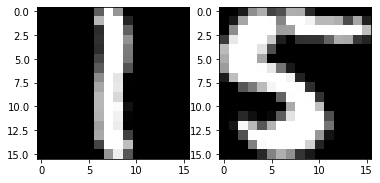

In [307]:
show_example_images()

In [0]:
one_images_train = train_d[train_label == 1]
five_images_train = train_d[train_label == 0]
one_images_test = test_d[test_label == 1]
five_images_test = test_d[test_label == 0]

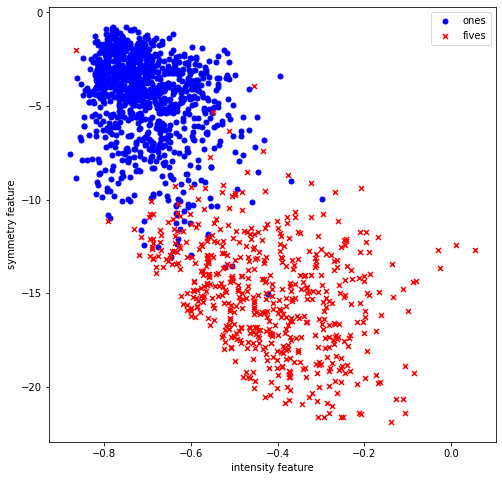

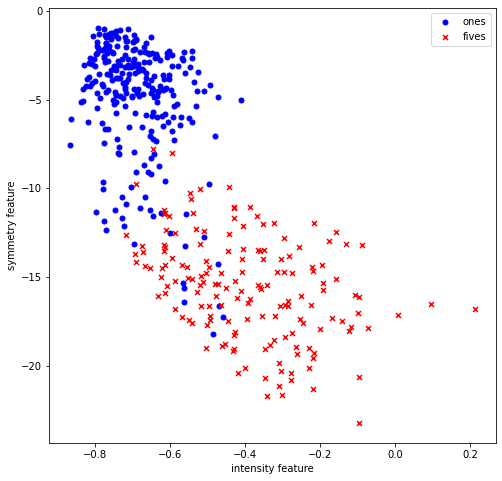

In [310]:
plot_features(one_images_train, five_images_train)
plot_features(one_images_test, five_images_test)

In [0]:
# ###################################################################
# ###################### NO NEED TO USE #############################
# ###################################################################
# Dataloader that will be used in logistic regression algorithm. 
# Each time this dataloader is called, it selects a random index between 
# 0 and (number of data points - batch size) to asssure each batch is full.
# Also after all data points are retrieved, it raises StopIteration exception
class DataLoader:
    def __init__(self, data, label, batch_size):
        data_and_label = list(zip(data, label))
        np.random.shuffle(data_and_label)
        data, label = zip(*data_and_label)
        ones = np.ones(np.array(data).shape[0])
        self.data = np.concatenate((ones.reshape(ones.shape[0],-1), np.array(data)),axis=1)
        self.label = np.array(label)
        self.batch_size = batch_size
        self.n_batches = int(np.floor(len(data) / batch_size))
        self.index = 0
        self.number_of_features = self.data.shape[1]
        print(self.data.shape, self.label.shape)

    def __next__(self):
        start_index = np.random.randint(0,len(self.data)-self.batch_size,1)[0]
        if self.index < self.n_batches:
            self.index += 1
            return self.data[start_index:start_index+self.batch_size], self.label[start_index:start_index+self.batch_size]
        self.index = 0
        raise StopIteration

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        return self


In [0]:
class LogisticRegression():
    def __init__(self):
        self.number_of_features = 2+1
        self.model = np.zeros((1,self.number_of_features))
        self.prev_loss = np.inf
        self.print_index = 0

    def reset(self):
        self.model = np.zeros((1,number_of_features))
        self.prev_loss = np.inf
        self.print_index = 0

    def sigmoid(self, data):
        return 1 / (1 + np.exp(-data))

    def loss_and_grad(self, train_data, train_label, reg_term):
        a = self.sigmoid(np.matmul(train_data, self.model.T))
        loss = (np.mean(- train_label * np.log(a) - (1 - train_label) * np.log(1-a))) + \
               (reg_term / 2.0) * np.sum(self.model ** 2) / self.model.shape[0]
        grad = np.mean((a - train_label) * train_data, axis=0) + \
               (reg_term * np.sum(self.model) / self.model.shape[0])
        return loss, grad

    def update_model(self, grad, lr):
        self.model -= grad * lr

    def predict(self, data, label):
        data = extract_features(
            data,
            create_intercept_terms,
            extract_symmetry_feature,
            extract_avg_intensity_feature
        )
        prob = self.sigmoid(np.matmul(data, self.model.T))
        prob[prob <= 0.5] = 0
        prob[prob > 0.5] = 1
        accuracy = np.sum((prob == label).astype(int)) / data.shape[0]
        return accuracy

    def fit(self, train_data, train_label, lr=1e-2, verbose=True, reg_term=0):
        train_label = train_label.reshape(-1,1)
        loss_vals = []
        while True:
            self.print_index += 1
            loss, grad = self.loss_and_grad(train_data, train_label, reg_term)
            self.update_model(grad, lr)
            if self.prev_loss - loss < 1e-6:
                break
            self.prev_loss = loss
            loss_vals.append(loss)    
            if verbose and self.print_index % 2000 == 0:
                print(loss)
        self.reset()
        return self.model, loss_vals


In [0]:
logistic_regression = LogisticRegression()

In [0]:
_, loss_vals1 = logistic_regression.fit(train_data, train_label, lr=5e-2, verbose=False)
_, loss_vals2 = logistic_regression.fit(train_data, train_label, lr=1e-2, verbose=False)
_, loss_vals3 = logistic_regression.fit(train_data, train_label, lr=5e-3, verbose=False)
_, loss_vals4 = logistic_regression.fit(train_data, train_label, lr=1e-3, verbose=False)
_, loss_vals5 = logistic_regression.fit(train_data, train_label, lr=5e-4, verbose=False)

Algorithim Is Done
Algorithim Is Done
Algorithim Is Done
Algorithim Is Done
Algorithim Is Done


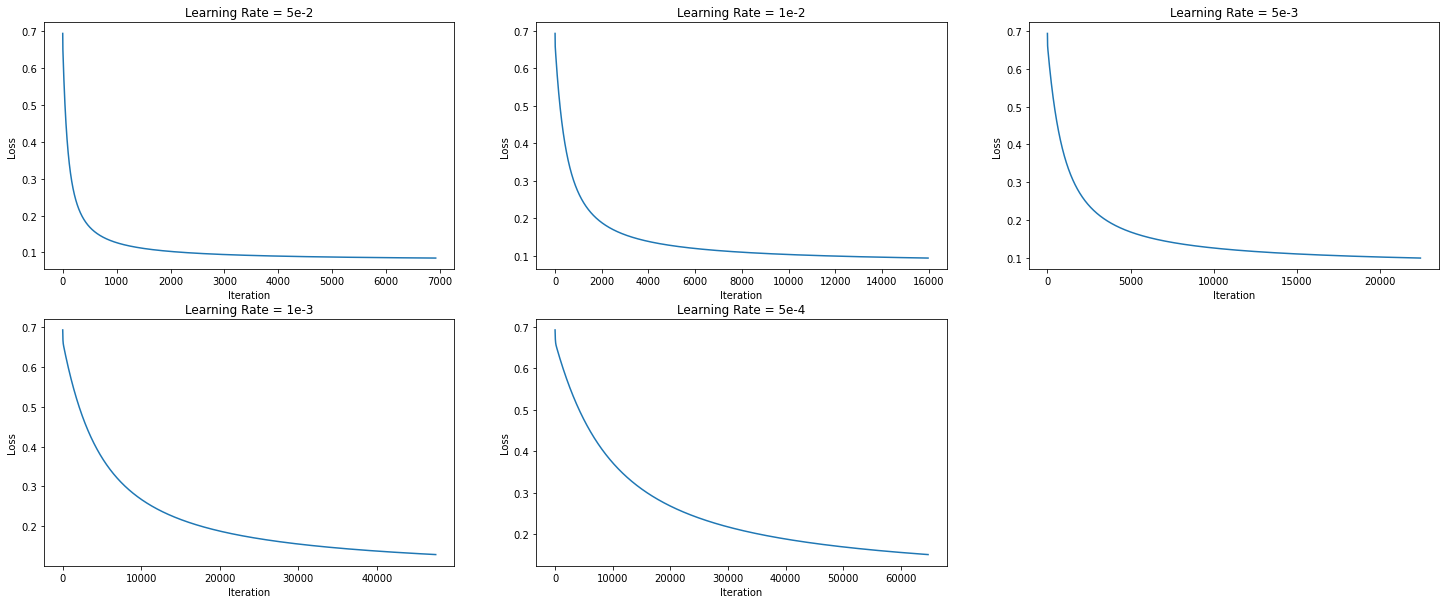

In [0]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)

ax1.plot(loss_vals1)
ax2.plot(loss_vals2)
ax3.plot(loss_vals3)
ax4.plot(loss_vals4)
ax5.plot(loss_vals5)

ax1.title.set_text('Learning Rate = 5e-2')
ax2.title.set_text('Learning Rate = 1e-2')
ax3.title.set_text('Learning Rate = 5e-3')
ax4.title.set_text('Learning Rate = 1e-3')
ax5.title.set_text('Learning Rate = 5e-4')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Loss")
ax5.set_xlabel("Iteration")
ax5.set_ylabel("Loss")

plt.show()

In [303]:
train_data.shape

(1561, 2)

In [314]:
_, loss_vals = logistic_regression.fit(train_data, train_label, verbose=True, lr=1e-3, reg_term=0.001)

Algorithim Is Done


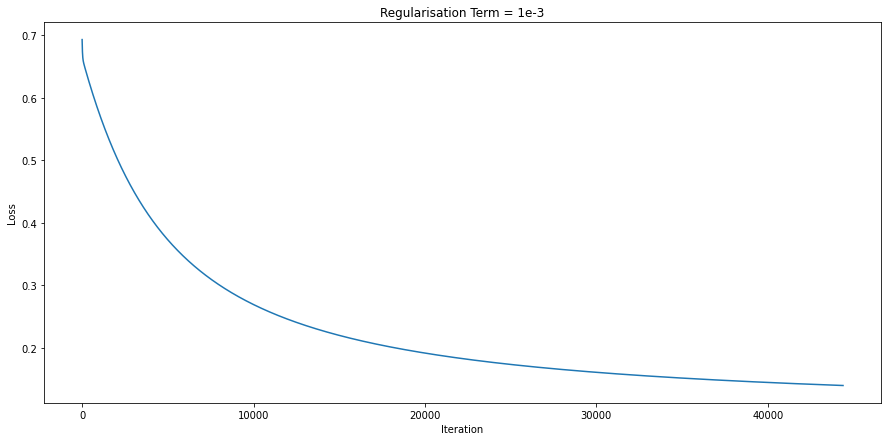

In [315]:
plt.figure(figsize=(15,7))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Regularisation Term = 1e-3")
plt.plot(loss_vals)
plt.show()

In [0]:
def cross_validation(train_data, train_label):
    partitions_data = np.array_split(train_data, 5)
    partitions_label = np.array_split(train_label, 5)

    configs = {}
    for l in [0.01, 0.001, 0.0001]:
        all_accuracies = []
        for i in range(5):
            train_data_set, train_label_set = [], []
            test_data_set, test_label_set = [], []

            for j in range(5):
                if i == j:
                    test_data_set.extend(partitions_data[j])
                    test_label_set.extend(partitions_label[j])
                else:
                    train_data_set.extend(partitions_data[j])
                    train_label_set.extend(partitions_label[j])

            train_data_set, train_label_set = np.array(train_data_set), np.array(train_label_set)
            test_data_set, test_label_set = np.array(test_data_set), np.array(test_label_set)

            model, loss_vals = logistic_regression.fit(train_data_set, train_label_set, lr=5e-2, verbose=False, reg_term=l)
            accuracy = logistic_regression.predict(test_data_set, test_label_set)
            all_accuracies.append(accuracy)

        configs[l] = all_accuracies
        
    return configs

In [0]:
configs = cross_validation(train_data, train_label)